# Transactions Fraud Detection

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Timotej Zatko](https://github.com/timzatko)

## Prototype #1 Grey Wolf Algorithm Application on Decision Tree Classifier

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

from NiaPy.task import StoppingTask, OptimizationType
from NiaPy.algorithms.basic import GreyWolfOptimizer

from src.algorithms.gray_wolf_optimizer_multiprocessing import GreyWolfOptimizerMultiprocessing

from src.dataset import load_processed_data
from src.evaluation import custom_classification_report

from src.classification_benchmark import ClassificationBenchmark

### Load the data

In [3]:
%%time

x_train, y_train, _, _ = load_processed_data(frac=0.2)

Number of records:
  x_train - 94486
  y_train - 94486
  x_test - 23621
  y_test - 23621
CPU times: user 26.4 s, sys: 1.91 s, total: 28.4 s
Wall time: 34.2 s


### Setup classification benchmark

In [4]:
def model_fn():
    return DecisionTreeClassifier(random_state=42)

In [5]:
columns_count = len(x_train.columns)

_x_train, _x_val, _y_train, _y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

benchmark = ClassificationBenchmark(
    model_fn,
    roc_auc_score,
    _x_train,
    _y_train,
    _x_val,
    _y_val
)

### Find optimal features

In [6]:
def optimize(benchmark, nGEN):
    """
    Optimize task with GWO optimizer.
    
    :param benchmark: NiaPy.Benchmark to optimize
    :param nGEN: number of generations
    """
    
    best_columns = None
    best_score = 0
    
    for i in range(5):
        # when using OptimizationType.MAXIMIZATION, the library will fail
        # we use OptimizationType.MINIMIZATION instead and invert the score
        task = StoppingTask(D=benchmark.get_length(), nGEN=nGEN, optType=OptimizationType.MINIMIZATION, benchmark=benchmark)
        # algo = GreyWolfOptimizer(NP=25)
        algo = GreyWolfOptimizerMultiprocessing(nodes=4, NP=25)
        solution_vec, score = algo.run(task=task)    
        
        # invert the score
        score = 1 - score
        columns = benchmark.select_columns(solution_vec)
        
        print(f'Score: {score}')
        print(columns)
        print('\n')
        
        if score > best_score:
            best_score = score
            best_columns = columns

    print('---')
    print(f'Score: {best_score}')
            
    return best_columns


Find the optimal combination of columns.

In [7]:
%%time

columns = optimize(benchmark, 100)

Score: 0.7030373501051757
['C3', 'C4', 'C5', 'C7', 'C8', 'C9', 'C11', 'D10', 'V3', 'V13', 'V14', 'V15', 'V16', 'V18', 'V19', 'V22', 'V26', 'V27', 'V31', 'V32', 'V34', 'V36', 'V37', 'V43', 'V44', 'V48', 'V52', 'V53', 'V55', 'V56', 'V58', 'V60', 'V61', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V79', 'V86', 'V87', 'V90', 'V91', 'V92', 'V94', 'V96', 'V97', 'V98', 'V99', 'V101', 'V103', 'V104', 'V106', 'V109', 'V112', 'V113', 'V114', 'V122', 'V123', 'V124', 'V131', 'V132', 'V134', 'V136', 'V137', 'V281', 'V288', 'V293', 'V295', 'V298', 'V301', 'V302', 'V305', 'V306', 'V308', 'V310', 'V314', 'V316', 'V317', 'V319', 'V320', 'V321', 'ProductCD_C', 'ProductCD_H', 'ProductCD_R', 'card1_other', 'card2_490.0', 'card2_555.0', 'card4_other', 'card6_debit', 'card6_other', 'addr1_other', 'addr2_87.0', 'P_emaildomain_anonymous', 'P_emaildomain_hotmail', 'P_emaildomain_nan', 'M1_T', 'M1_other']


Score: 0.708152879960965
['TransactionDT', 'C3', 'C5', 'C7', 'C8'

We found the best solution from 5 independent runs of GWO algorithm. During every run we captured a different solution. For the final submission, we probably would not like to use "the best one", because we would like to have some variance. Maybe we can try to merge these solution together.

### Train only with selected features and evaluate on test data

We will train the model with selected features on the whole dataset.

In [8]:
x_train, y_train, x_test, y_test = load_processed_data()

Number of records:
  x_train - 472432
  y_train - 472432
  x_test - 118108
  y_test - 118108


Train classifier with selected features.

In [9]:
%%time

clf = model_fn()
clf = clf.fit(x_train[columns], y_train)

CPU times: user 35.5 s, sys: 579 ms, total: 36.1 s
Wall time: 36.5 s


Evaluate trained model.

not fraud
precision: 0.9794846574043173
recall: 0.98235755242969
f1-score: 0.9809190014028206
support: 113533


is fraud
precision: 0.5278170674210279
recall: 0.4893989071038251
f1-score: 0.5078824997164568
support: 4575


accuracy: 0.9632624377688218


macro avg
precision: 0.7536508624126725
recall: 0.7358782297667575
f1-score: 0.7444007505596387
support: 118108


weighted avg
precision: 0.9619889820548614
recall: 0.9632624377688218
f1-score: 0.9625955855866599
support: 118108


Area Under the Receiver Operating Characteristic Curve (ROC AUC)
micro: 0.7536508624126727
macro: 0.7536508624126727
samples: 0.7536508624126727
weighted: 0.7536508624126727


CPU times: user 572 ms, sys: 8.53 ms, total: 580 ms
Wall time: 640 ms


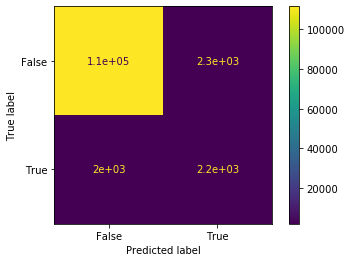

In [10]:
%%time

custom_classification_report(clf, x_test[columns], y_test)